In [2]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta
from sgp4.api import Satrec, WGS72, jday
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objects as go
import nbformat

In [3]:
USERNAME = "EMAIL"
PASSWORD = "PASSWORD"

LOGIN_URL = "https://www.space-track.org/ajaxauth/login"
QUERY_URL = (
    "https://www.space-track.org/basicspacedata/query/"
    "class/gp/EPOCH/%3Enow-30/MEAN_MOTION/%3E11.25/"
    "ECCENTRICITY/%3C0.25/OBJECT_TYPE/payload/"
    "orderby/NORAD_CAT_ID,EPOCH/format/3le"
)

In [4]:
# Earth radius in kilometers
EARTH_RADIUS = 6371
SNAPSHOT_TIME = datetime(2025, 1, 20, 0, 0, 0)
DURATION_MINUTES = 1440  # 24 hours
STEP_SECONDS = 60
ORBIT_SUBSET = 5

# Functions

### Data retrieval and parsing

In [5]:
# Log into Space-Track and retrieve TLE data
def fetch_tle_text(username, password, login_url=LOGIN_URL, query_url=QUERY_URL):

    with requests.Session() as session:
        # Log in
        login_data = {"identity": username, "password": password}
        login_resp = session.post(login_url, data=login_data)
        login_resp.raise_for_status()
        
        # Perform the query
        resp = session.get(query_url)
        resp.raise_for_status()
        
        return resp.text


# Take TLE response and parse it into 3-line format (0/1/2) with columns 'name', 'line1', and 'line2'.
def parse_tle_to_dataframe(tle_text):
    lines = [line.strip() for line in tle_text.strip().splitlines() if line.strip()]
    satellites = []

    # Check for bad lines if dataset is not a multiple of 3
    if len(lines) % 3 != 0:
        print("Warning: The number of lines is not a multiple of 3. Some TLE entries may be incomplete.")

    # Loop through each line and pull data
    for i in range(0, len(lines) - 2, 3):
        name_line = lines[i]
        line1 = lines[i + 1]
        line2 = lines[i + 2]

        # Check for errors in line data
        if not name_line.startswith("0"):
            print(f"Unexpected format in name line: '{name_line}'. Skipping this entry.")
            continue
        if not line1.startswith("1"):
            print(f"Unexpected format in Line 1: '{line1}'. Skipping this entry.")
            continue
        if not line2.startswith("2"):
            print(f"Unexpected format in Line 2: '{line2}'. Skipping this entry.")
            continue

        name = name_line[1:].strip()  # Remove leading "0"
        satellites.append({"Name": name, "Line1": line1, "Line2": line2})

    return pd.DataFrame(satellites, columns=["Name", "Line1", "Line2"])

### Extract launch year and epoch

In [6]:
# Grab 4-digit launch year data from line 1
def extract_launch_year(line1):
    try:
        parts = line1.split()
        int_designator = parts[2]
        yy = int(int_designator[:2])

        # TLE convention:  if year is >= 57 then it's a 19xx prefix,, else 20xx
        if yy >= 57:
            return 1900 + yy
        else:
            return 2000 + yy
    except (IndexError, ValueError) as e:
        print(f"Error extracting launch year from Line1: '{line1}'. Error: {e}")
        return None

# Grab datetime from the epoch in line 1
def extract_tle_epoch(line1):
    try:
        match = re.search(r'(\d{2})(\d{3}\.\d+)', line1)
        if not match:
            return None
        
        year = int(match.group(1))
        day_of_year = float(match.group(2))

        # TLE year pivot
        if year >= 57:
            year += 1900
        else:
            year += 2000

        # day_of_year may have a fractional part => convert to seconds
        base_date = datetime(year, 1, 1)
        epoch_date = base_date + timedelta(
            days=int(day_of_year) - 1,
            seconds=(day_of_year % 1) * 86400
        )
        return epoch_date
    except Exception as e:
        print(f"Error extracting epoch: {e}")
        return None

### SGP4 Propogation

In [7]:
# Extract satellite position (x,y,z) in KM in the ECI frame for given time
def get_satellite_position(line1, line2, when):
    try:
        sat = Satrec.twoline2rv(line1, line2, WGS72)
        jd, fr = jday(
            when.year, when.month, when.day,
            when.hour, when.minute, when.second + when.microsecond * 1e-6
        )
        error_code, r, v = sat.sgp4(jd, fr)
        if error_code != 0:
            print(f"SGP4 Error {error_code} for Satellite: {sat.satnum}")
            return None
        return r
    except Exception as e:
        print(f"Exception during propagation: {e}")
        return None

# Propogate satellite positions over a given duration to create orbital tracks
def get_satellite_tracks(line1, line2, start_datetime, duration_minutes=90, step_seconds=30):
    """
    Propagate satellite positions over a duration, returning (x, y, z) arrays.
    """
    sat = Satrec.twoline2rv(line1, line2, WGS72)
    positions_x, positions_y, positions_z = [], [], []

    total_steps = int((duration_minutes * 60) / step_seconds)
    for step in range(total_steps + 1):
        current_time = start_datetime + timedelta(seconds=step * step_seconds)
        jd, fr = jday(
            current_time.year, current_time.month, current_time.day,
            current_time.hour, current_time.minute, current_time.second + current_time.microsecond * 1e-6
        )
        e, r, v = sat.sgp4(jd, fr)
        if e == 0:
            positions_x.append(r[0])
            positions_y.append(r[1])
            positions_z.append(r[2])
        else:
            positions_x.append(np.nan)
            positions_y.append(np.nan)
            positions_z.append(np.nan)

    return positions_x, positions_y, positions_z

### Main function

In [8]:
def pull_tle_data():
    """
    1) Fetch raw TLE data from Space-Track
    2) Parse into DataFrame
    3) Add Launch Year & TLE Epoch
    4) Filter for recency (<= 30 days)
    5) For each satellite in the filtered DataFrame:
         - Get single snapshot x, y, z (in km)
         - Collect launch year in a separate list
    6) For a subset of satellites (ORBIT_SUBSET), get orbital tracks
    7) Return:
         - The filtered DataFrame
         - Lists (xs, ys, zs, launch_years)
         - A list of track dictionaries for the subset
    """
    # 1) Fetch
    tle_text = fetch_tle_text(USERNAME, PASSWORD)

    # 2) Parse
    df = parse_tle_to_dataframe(tle_text)

    # 3) Enrich with Launch Year & Epoch
    df['Launch Year'] = df['Line1'].apply(extract_launch_year)
    df['Epoch'] = df['Line1'].apply(extract_tle_epoch)

    # 4) Filter TLEs by epoch recency (<= 30 days)
    df['Epoch_Diff_Days'] = df['Epoch'].apply(
        lambda x: abs((datetime.utcnow() - x).days) if x else None
    )
    filtered_df = df[(df['Epoch_Diff_Days'] <= 30) & df['Epoch_Diff_Days'].notnull()]

    print(f"Number of TLEs after filtering: {len(filtered_df)}")

    # 5) Get x, y, z for each satellite at a single snapshot time
    xs, ys, zs = [], [], []
    launch_years = []
    for _, row in filtered_df.iterrows():
        pos = get_satellite_position(row['Line1'], row['Line2'], SNAPSHOT_TIME)
        if pos is not None:
            xs.append(pos[0])
            ys.append(pos[1])
            zs.append(pos[2])
            launch_years.append(row['Launch Year'])
        else:
            # If propagation error, append NaN or skip
            xs.append(np.nan)
            ys.append(np.nan)
            zs.append(np.nan)
            launch_years.append(np.nan)

    # 6) Generate orbital tracks for a subset of satellites
    #    using the global (or top-of-notebook) parameters.
    subset_df = filtered_df.head(ORBIT_SUBSET)
    orbits_data = []
    for idx, row in subset_df.iterrows():
        track_x, track_y, track_z = get_satellite_tracks(
            row['Line1'], row['Line2'],
            SNAPSHOT_TIME,
            duration_minutes=DURATION_MINUTES,
            step_seconds=STEP_SECONDS
        )
        orbits_data.append({
            'Index': idx,
            'Name': row['Name'],
            'Launch Year': row['Launch Year'],
            'X_track': track_x,
            'Y_track': track_y,
            'Z_track': track_z
        })

    # 7) Return the final objects
    return filtered_df, xs, ys, zs, launch_years, orbits_data

filtered_tle_df, xs, ys, zs, launch_years, orbits_data = pull_tle_data()

Number of TLEs after filtering: 11405
SGP4 Error 1 for Satellite: 13271
SGP4 Error 1 for Satellite: 28773
SGP4 Error 6 for Satellite: 40300
SGP4 Error 6 for Satellite: 41907
SGP4 Error 6 for Satellite: 43818
SGP4 Error 6 for Satellite: 43883
SGP4 Error 1 for Satellite: 44519
SGP4 Error 1 for Satellite: 44760
SGP4 Error 1 for Satellite: 45089
SGP4 Error 1 for Satellite: 45562
SGP4 Error 1 for Satellite: 45734
SGP4 Error 1 for Satellite: 45757
SGP4 Error 1 for Satellite: 45767
SGP4 Error 1 for Satellite: 46062
SGP4 Error 1 for Satellite: 46071
SGP4 Error 1 for Satellite: 46121
SGP4 Error 1 for Satellite: 46268
SGP4 Error 6 for Satellite: 46287
SGP4 Error 1 for Satellite: 46675
SGP4 Error 1 for Satellite: 46711
SGP4 Error 1 for Satellite: 46768
SGP4 Error 1 for Satellite: 47167
SGP4 Error 1 for Satellite: 47174
SGP4 Error 1 for Satellite: 47363
SGP4 Error 1 for Satellite: 47372
SGP4 Error 1 for Satellite: 47394
SGP4 Error 1 for Satellite: 47402
SGP4 Error 1 for Satellite: 47620
SGP4 Error

# Plotting

### Histogram of launch count by year

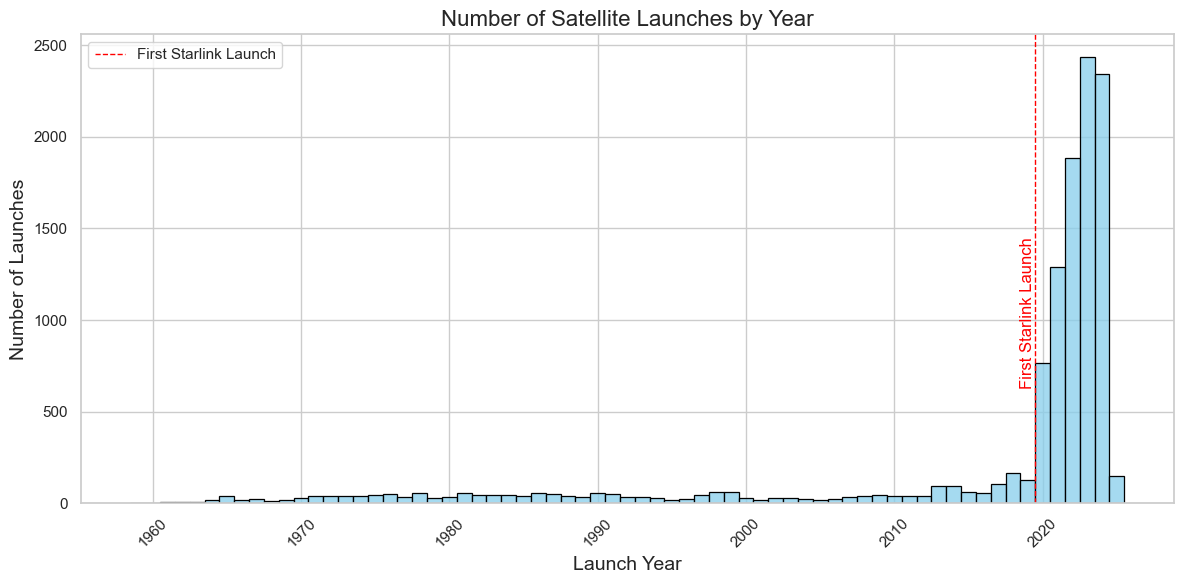

In [9]:
# You can set these parameters inline:
BINSIZE = 1  # Just an example parameter
STARLINK_LINE = 2019.45

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# If you want to control the bin range more precisely:
min_year = filtered_tle_df['Launch Year'].min()
max_year = filtered_tle_df['Launch Year'].max()
bins = range(min_year, max_year + 2, BINSIZE)

sns.histplot(
    data=filtered_tle_df,
    x='Launch Year',
    bins=bins,
    discrete=True,
    kde=False,
    color='skyblue',
    edgecolor='black'
)

plt.title('Number of Satellite Launches by Year', fontsize=16)
plt.xlabel('Launch Year', fontsize=14)
plt.ylabel('Number of Launches', fontsize=14)

# Annotate
plt.axvline(x=STARLINK_LINE, color='red', linestyle='--', label='First Starlink Launch', linewidth=1)
plt.annotate(
    'First Starlink Launch',
    xy=(STARLINK_LINE, plt.ylim()[1] * 0.25),
    xytext=(STARLINK_LINE - 1, plt.ylim()[1] * 0.25),
    color='red',
    fontsize=12,
    rotation=90,
)

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Positions and tracks in 3D

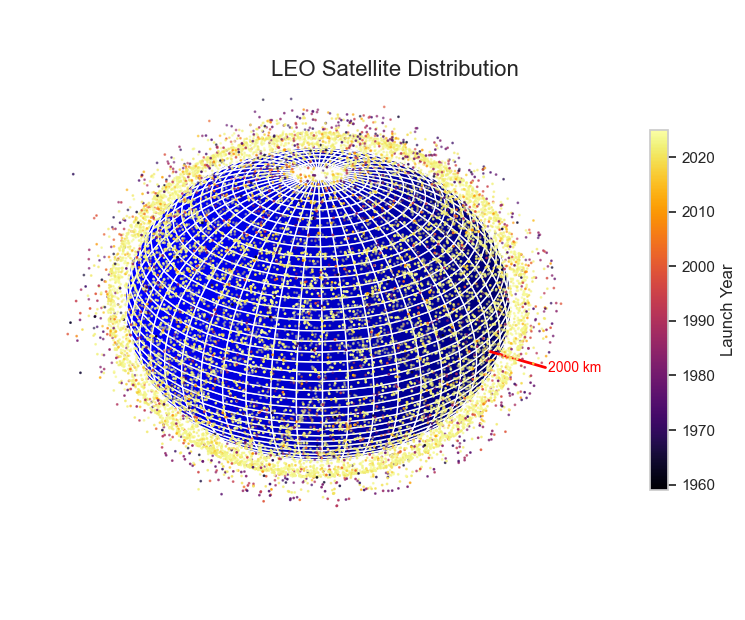

In [10]:
# Plot 3D satellite positions
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
fig.suptitle("LEO Satellite Distribution", fontsize=16, x=0.525, y=0.75)

# Scatter-plot for positions, color-coded by launch year
sc = ax.scatter(xs, ys, zs, s=1, c=launch_years, cmap='inferno')

# Wireframe for Earth surface
u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
x_earth = EARTH_RADIUS * np.cos(u) * np.sin(v)
y_earth = EARTH_RADIUS * np.sin(u) * np.sin(v)
z_earth = EARTH_RADIUS * np.cos(v)
ax.plot_surface(x_earth, y_earth, z_earth, color='blue', alpha=1.0)

# Radial line for scale
extension = 2000
line_len = EARTH_RADIUS + extension
ax.plot([EARTH_RADIUS, line_len], [0, 0], [0, 0], color='red', linewidth=2)
ax.text(
    line_len + 100, 0, 0,
    f"{extension} km",
    color='red',
    fontsize=10,
    horizontalalignment='left',
    verticalalignment='center'
)

max_val = EARTH_RADIUS
ax.set_xlim(-max_val, max_val)
ax.set_ylim(-max_val, max_val)
ax.set_zlim(-max_val, max_val)

# Hide ticks
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax._axis3don = False

# Colorbar
cbar = fig.colorbar(sc, ax=ax, shrink=0.6)
cbar.set_label('Launch Year', fontsize=12)

plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.2)
plt.show()

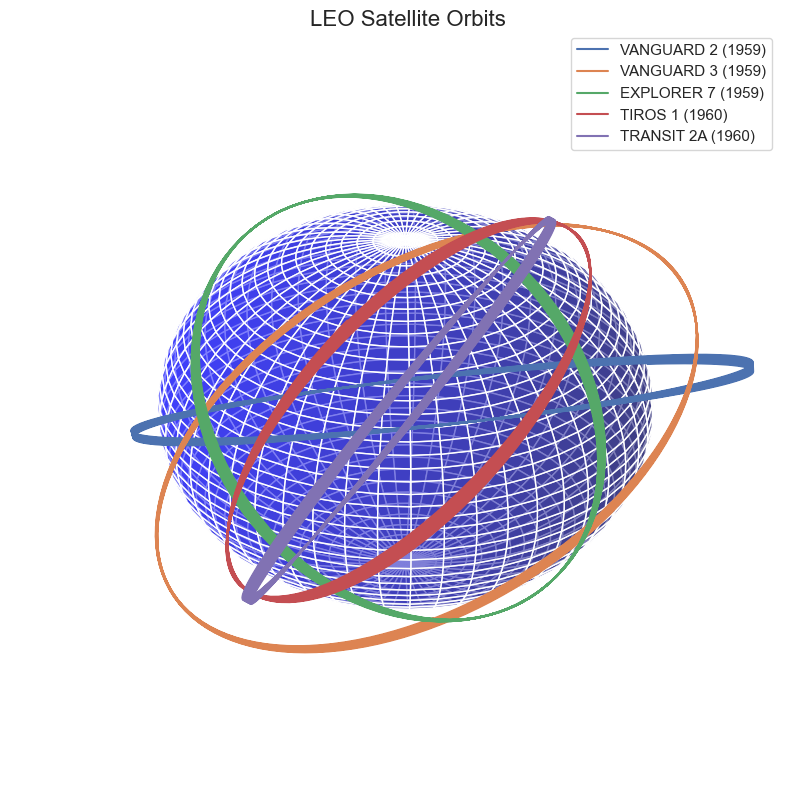

In [11]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
fig.suptitle("LEO Satellite Orbits", fontsize=16, x=0.525, y=0.9)
# Plot Earth
u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
x_earth = EARTH_RADIUS * np.cos(u) * np.sin(v)
y_earth = EARTH_RADIUS * np.sin(u) * np.sin(v)
z_earth = EARTH_RADIUS * np.cos(v)
ax.plot_surface(x_earth, y_earth, z_earth, color='blue', alpha=0.5)
for orbit in orbits_data:
    ax.plot(
        orbit['X_track'],
        orbit['Y_track'],
        orbit['Z_track'],
        label=f"{orbit['Name']} ({orbit['Launch Year']})"
    )



max_val = EARTH_RADIUS

ax.set_xlim(-max_val, max_val)
ax.set_ylim(-max_val, max_val)
ax.set_zlim(-max_val, max_val)

# Hide ticks
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax._axis3don = False

ax.legend()
plt.show()

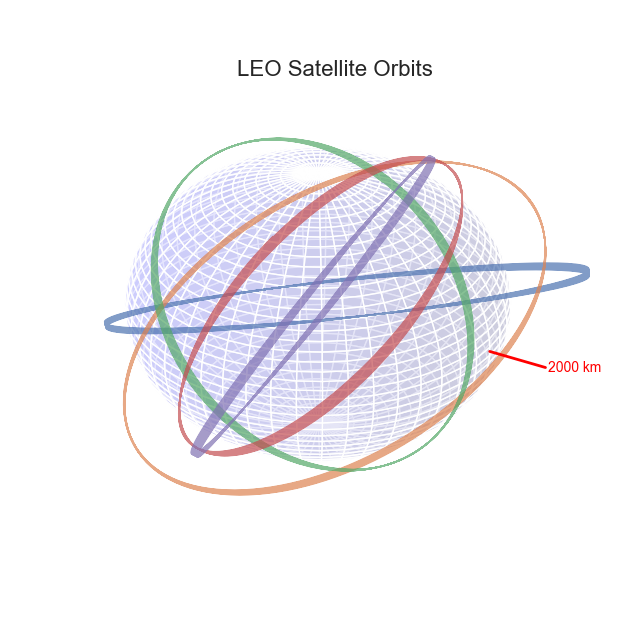

In [12]:
DURATION_MINUTES = 1440  # 24 hours
STEP_SECONDS = 60
ORBIT_SUBSET = 5  # number of orbits to plot

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
fig.suptitle("LEO Satellite Orbits", fontsize=16, x=0.525, y=0.75)

# Plot orbits for a subset
subset_df = filtered_tle_df.head(ORBIT_SUBSET)
for idx, row in subset_df.iterrows():
    x_track, y_track, z_track = get_satellite_tracks(
        row['Line1'], row['Line2'],
        SNAPSHOT_TIME,
        duration_minutes=DURATION_MINUTES,
        step_seconds=STEP_SECONDS
    )
    ax.plot(
        x_track, y_track, z_track,
        linewidth=1, alpha=0.7, zorder=2, 
        label=f"Orbit {idx} (Launch Year: {row['Launch Year']})"
    )

# Plot Earth
u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
x_earth = EARTH_RADIUS * np.cos(u) * np.sin(v)
y_earth = EARTH_RADIUS * np.sin(u) * np.sin(v)
z_earth = EARTH_RADIUS * np.cos(v)
ax.plot_surface(x_earth, y_earth, z_earth, color='blue', alpha=0.1)

# Radial line
extension = 2000
line_len = EARTH_RADIUS + extension
ax.plot([EARTH_RADIUS, line_len], [0, 0], [0, 0], color='red', linewidth=2)
ax.text(
    line_len + 100, 0, 0,
    f"{extension} km",
    color='red',
    fontsize=10,
    horizontalalignment='left',
    verticalalignment='center'
)

max_val = EARTH_RADIUS 

ax.set_xlim(-max_val, max_val)
ax.set_ylim(-max_val, max_val)
ax.set_zlim(-max_val, max_val)

# Hide ticks
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax._axis3don = False

#ax.legend(loc='lower left', bbox_to_anchor=(0.1, 0.1), fontsize=12)
plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.2)
plt.show()

In [13]:
# Create Earth sphere
u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
x_earth = EARTH_RADIUS * np.cos(u) * np.sin(v)
y_earth = EARTH_RADIUS * np.sin(u) * np.sin(v)
z_earth = EARTH_RADIUS * np.cos(v)
earth = go.Surface(x=x_earth, y=y_earth, z=z_earth, colorscale='Blues', opacity=0.75, showscale=False)

# Create orbital tracks
tracks = []
for orbit in orbits_data:
    tracks.append(go.Scatter3d(
        x=orbit['X_track'],
        y=orbit['Y_track'],
        z=orbit['Z_track'],
        mode='lines',
        name=f"{orbit['Name']} ({orbit['Launch Year']})",
        line=dict(width=2)
    ))

# Define layout
layout = go.Layout(
    title="LEO Satellite Orbits",
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
        aspectmode='data'
    ),
    showlegend=True,
    height=1200,
    width=1000
)

# Create figure
fig = go.Figure(data=[earth] + tracks, layout=layout)
fig.show()


In [14]:

print(nbformat.__version__)

5.10.4


# Calculate average distance between satellites


In [17]:
from scipy.spatial.distance import pdist

In [16]:
# Convert lists to NumPy arrays for efficiency
xs = np.array(xs)
ys = np.array(ys)
zs = np.array(zs)

# Combine into a single 2D array of shape (N, 3), where N is the number of satellites
positions = np.vstack((xs, ys, zs)).T  # Shape: (N, 3)

# Remove any rows with NaN values
valid_positions = positions[~np.isnan(positions).any(axis=1)]

# Update N after removing invalid entries
N = valid_positions.shape[0]

print(f"Number of valid satellite positions: {N}")

Number of valid satellite positions: 11302


In [18]:
# Compute all pairwise Euclidean distances
pairwise_distances = pdist(valid_positions, metric='euclidean')  # Returns a condensed distance matrix

print(f"Total number of unique pairs: {len(pairwise_distances)}")

Total number of unique pairs: 63861951


In [20]:
average_distance = pairwise_distances.mean()
min_distance = pairwise_distances.min()
max_distance = pairwise_distances.max()
print(f"Minimum pairwise distance: {min_distance:.2f} km")
print(f"Maximum pairwise distance: {max_distance:.2f} km")

Minimum pairwise distance: 0.00 km
Maximum pairwise distance: 17793.15 km


In [46]:
positions = np.vstack((xs, ys, zs)).T  # Shape: (N, 3)

# Remove satellites with NaN positions
valid_positions = positions[~np.isnan(positions).any(axis=1)]
N = valid_positions.shape[0]

# Find unique positions and their counts
unique_positions, counts = np.unique(valid_positions, axis=0, return_counts=True)

# Identify positions that appear more than once
duplicate_positions = unique_positions[counts > 1]
print(f"Number of duplicate positions: {len(duplicate_positions)}")

# Optionally, display the duplicate positions
print("Duplicate position coordinates (x, y, z):")
print(duplicate_positions)

Number of duplicate positions: 2
Duplicate position coordinates (x, y, z):
[[-4503.46106678 -1361.49335915 -4908.80620551]
 [  547.22917096 -5132.107194    4375.18739743]]


In [47]:
filtered_tle_df_unique = filtered_tle_df.drop_duplicates(subset=['Name'], keep='first')
print(f"Number of satellites after removing duplicates: {len(filtered_tle_df_unique)}")

Number of satellites after removing duplicates: 11401


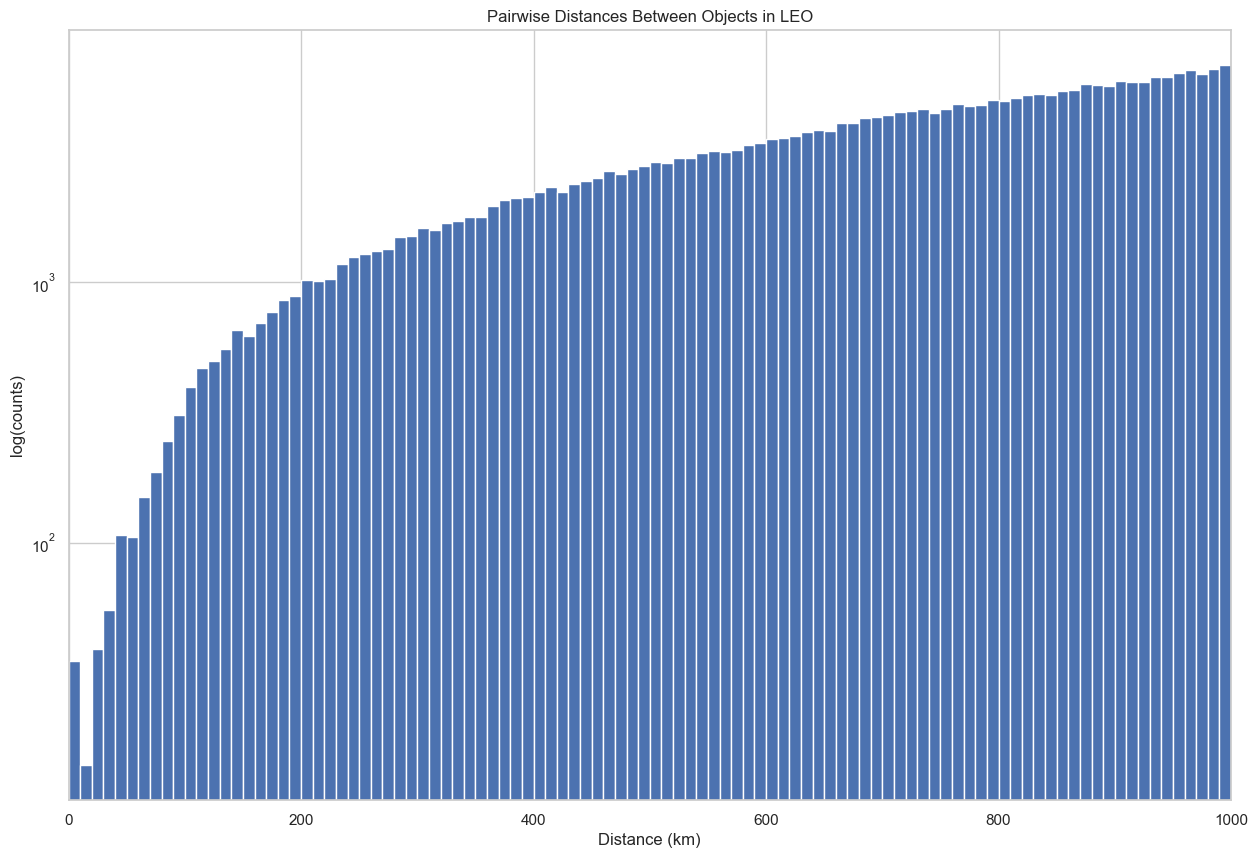

In [45]:
fig = plt.figure(figsize=(15,10))
plt.title('Pairwise Distances Between Objects in LEO')
plt.ylabel('log(counts)')
plt.xlabel('Distance (km)')
plt.hist(pairwise_distances, range=(0,1000), bins=100)
plt.axvline(x=2*EARTH_RADIUS, color='red', label='Earth Diameter')
plt.annotate(
    'Earth Diameter',
    xy=(2*EARTH_RADIUS, plt.ylim()[1] ),
    xytext=(2*EARTH_RADIUS - 1, plt.ylim()[1]),
    color='red',
    fontsize=12,
    rotation=45,
)
plt.xlim(0,1000)
plt.yscale('log')
plt.show()